In [ ]:
!nvidia-smi

## Import

In [31]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

In [ ]:
torch.cuda.is_available()

In [89]:
# 클래스 수
num_classes = 12

# 각 클래스에 대한 색상 정의 (임의의 값)
colors = np.array([[255,0,0], #red
                   [255,140,0], #orange
                   [255,255,0], #yellow
                   [0,128,0], #green
                   [42,255,255],
                   [0,0,255], #blue
                   [75,0,130], #indigo
                   [128,0,128], #purple
                   [120,255,42],
                   [250,200,42],
                   [255,42,255],
                   [255,42,70],
                   ])

In [88]:
print(colors[0])

[3 4 5]


## Utils

In [78]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 디코딩 함수
def rle_decode2(mask_rle, shape, i):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = i
    return img.reshape(shape)

# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

def visualize_combined_masks(rle_data_list, shape):
    combined_mask = np.zeros(shape, dtype=np.uint8)
    i = 0
    for rle_data in rle_data_list:
        i += 1
        mask = rle_decode2(rle_data, shape, i)
        #np.savetxt(f"./output{i}.txt", mask, fmt="%d")
        combined_mask += mask
    #np.savetxt("./combine.txt", combined_mask, fmt="%d")
    if np.any(combined_mask > 12):
        print("ERROR")
    #visualize(combined_mask=combined_mask)
    return combined_mask

def blend_images(image1, image2, alpha):
    """
    Blend two images using alpha transparency
    """
    blended_image = alpha * image1 + (1 - alpha) * image2
    return blended_image.astype(np.uint8)

def visualize_with_transparency(image1, image2, alpha):
    """
    Visualize two images with transparency
    """
    blended_image = blend_images(image1, image2, alpha)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image1)
    plt.title("Image 1")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(image2)
    plt.title("Image 2")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(blended_image)
    plt.title("Blended Image")
    plt.axis('off')
    
    plt.show()

def blend_images(image1, image2, alpha):
    """
    Blend two images using alpha transparency
    """
    blended_image = alpha * image1 + (1 - alpha) * image2
    return blended_image.astype(np.uint8)

def grayscale_to_rgb(image):
    """
    Convert grayscale image to RGB
    """
    """kk=np.stack((image, image, image), axis=-1)
    print(kk.shape)"""
    # shape 변경
    #new_shape = image.shape + (-1,)  # -1을 추가하여 (x, y, -1) 형태로 만듭니다.
    #image = image.reshape(new_shape)
    #image = ((image/12.0)*255.0).astype(np.uint8)
    #image = np.stack((image, image, image), axis=-1)
    #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # 클래스에 해당하는 색상으로 변환
    colored_mask = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    for class_index in range(num_classes):
        colored_mask[image == class_index] = colors[class_index]
    return colored_mask

def visualize_with_transparency(image1, image2, alpha):
    """
    Visualize two images with transparency
    """
    # Convert grayscale image to RGB if necessary
    if len(image2.shape) == 2:  # If image2 is grayscale
        image2 = grayscale_to_rgb(image2)
    
    blended_image = blend_images(image1, image2, alpha)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image1)
    plt.title("Image 1")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(image2)
    plt.title("Image 2")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(blended_image)
    plt.title("Blended Image")
    plt.axis('off')
    
    plt.show()

#def visualize_images_masks(image, combined_mask, shape):
    

## Custom Dataset

In [10]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image
        
        mask_path = self.data.iloc[idx, 2]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask[mask == 255] = 12 #배경을 픽셀값 12로 간주

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            #augmented = self.transform(image=image)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Data Loader

In [ ]:
transform = A.Compose(
    [   
        A.Resize(224, 448),
        #A.Normalize(),
        ToTensorV2()
    ]
)

dataset = CustomDataset(csv_file='./train_source.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
print(len(dataset))

## Image Check

In [ ]:
visual_transform = A.Compose(
    [   
        A.Resize(224, 448),
        #A.Normalize(),
        ToTensorV2()
    ]
)

visual_dataset = CustomDataset(csv_file='./train_source.csv', transform=visual_transform)
#print(len(visual_dataset[0]))
print(visual_dataset[1])

for i in range(5):
    v_image, v_mask = visual_dataset[i] # get some sample
    visualize(
    image=v_image.reshape(224, 448, 3),
    mask=v_mask
)

## RLE ENCODE & RLE DECODE Test

In [ ]:
rle_test_data = visual_dataset[0][1]
#print(rle_test_data)
#print(len(rle_test_data))
#print(len(rle_test_data[0]))

re = rle_encode(rle_test_data)
print(re)

rd = rle_decode(re, (224, 448))
print(rd)

visualize(
    image=rd.reshape(224, 448, 1),
)

## Define Model

In [ ]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 13, 1) # 12개 class + 1 background

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   

        x = self.dconv_down4(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

## Model Train

In [ ]:
EPOCH = 0

# model 초기화
model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(EPOCH, 20):  # 20 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')
    
    if (epoch + 1) % 5 == 0:
      torch.save({
          "model": "U-Net",
          "epoch": epoch,
          "model_state_dict": model.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "epoch_loss": epoch_loss,
          "description": f"U-Net 체크포인트-{epoch + 1:04d}"
        },
            f"./model/checkpoint-{epoch + 1:04d}.pth"
      )
      print("Model Saved!")

## Inference

In [ ]:
EPOCH = 0

# model 초기화
model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load('./model/checkpoint-0020.pth')
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
EPOCH = checkpoint["epoch"]
checkpoint_description = checkpoint["description"]

print(checkpoint_description)

In [ ]:
test_dataset = CustomDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        outputs = model(images)
        outputs = torch.softmax(outputs, dim=1).cpu()
        outputs = torch.argmax(outputs, dim=1).numpy()
        # batch에 존재하는 각 이미지에 대해서 반복
        for pred in outputs:
            pred = pred.astype(np.uint8)
            pred = Image.fromarray(pred) # 이미지로 변환
            pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
            pred = np.array(pred) # 다시 수치로 변환
            # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
            for class_id in range(12):
                class_mask = (pred == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else: # 마스크가 존재하지 않는 경우 -1
                    result.append(-1)

## Submission

In [8]:
submit = pd.read_csv('./baseline_submit.csv')
#submit['mask_rle'] = result
#submit

In [ ]:
submit.to_csv('./baseline_submit.csv', index=False)

In [ ]:
print(np.array(result).shape)

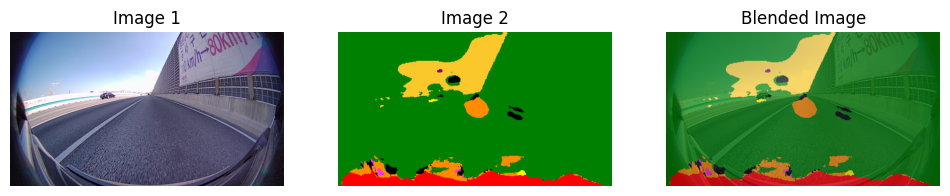

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=uint8)

In [90]:
#print(submit['mask_rle'][0])
#print(len(submit['mask_rle'][0]))

sub = []
k = 0 # k번째 이미지
for i in range(k*12, k*12+12):
    sub.append(submit['mask_rle'][i])

visual_transform2 = A.Compose(
    [   
        A.Resize(540, 960),
        #A.Normalize(),
        #ToTensorV2()
    ]
)

test2 = CustomDataset(csv_file='./test.csv', transform=visual_transform2, infer=True)

#visualize_images_masks
test_image2 = test2[0]
test_mask2 = visualize_combined_masks(sub, (540, 960))
#visualize(mask=test_mask2)
#visualize(image=test_image2)
#visualize(mask=sub)
visualize_with_transparency(test_image2, test_mask2, 0.3)

"""
vs = rle_decode(submit['mask_rle'][1], (540, 960, 1))

visualize(
    image=vs.reshape(540, 960, 1),
)
"""
"""for i in range(1897):
    sub = []
    k = i # k번째 이미지
    for j in range(k*12, k*12+12):
        sub.append(submit['mask_rle'][j])
    visualize_combined_masks(sub, (540, 960))
"""

#print(len(sub))
visualize_combined_masks(sub, (540, 960))
#su=rle_decode(sub[11], (540, 960))
#visualize(image=su)